In [ ]:
# Import library 
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd 
import cv2
import os
import mediapipe as mp

In [ ]:
# Drawing and model mediapipe processing
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

mp_model = mp_hands.Hands(
    static_image_mode=True, # static images
    max_num_hands=1, # max 1 hands detection
    min_detection_confidence=0.5) # detection confidence

In [ ]:
# Increasing brightness
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [ ]:
# Convert keypoints
def convert_keypoints(keypoints):
    x = keypoints[0]*200
    y = keypoints[1]*200
    z = keypoints[2]*100
    for j in range(63):
        if j % 3 == 0:
            keypoints[j] = keypoints[j]*200 - x
        elif j % 3 == 1:
            keypoints[j] = keypoints[j]*200 - y
        else:
            keypoints[j] = keypoints[j]*100 - z

In [ ]:
# Extract keypoints
def extract_keypoints(results):
    array_of_zeros = np.zeros(21*3)
    if results.multi_hand_landmarks != None:
        for handLandMarks in results.multi_hand_landmarks:
            landmark = []
            for landMark in handLandMarks.landmark:
                landmark.append((landMark.x, landMark.y, landMark.z))
            keypoint = np.array(landmark).flatten()
    else:
        keypoint = array_of_zeros
    return keypoint

In [ ]:
# Loading data
train_df_dir = 'C:/ASL train data/asl_alphabet_train/asl_alphabet_train'

def get_data(folder):
    keypoints = []
    labels = []
    count = 0
    for idx, label in enumerate(uniq_labels):
        for file in os.listdir(folder + '/' + label):
            filepath = folder + "/" + label + "/" + file
            image = cv2.imread(filepath)
            image = increase_brightness(image, 20)
            results = mp_model.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            keypoint = extract_keypoints(results)

            keypoints.append(keypoint)
            labels.append(idx)
            count += 1
            print(count)
    keypoints = np.array(keypoints)
    labels = np.array(labels)
    return (keypoints, labels)


uniq_labels = sorted(os.listdir(train_df_dir))
keypoints, labels = get_data(folder=train_df_dir)

In [ ]:
#Saving data 
np.save('D:/Keypoints/keypoints.npy', keypoints, allow_pickle=True)
np.save('D:/Keypoints/labels.npy', labels, allow_pickle=True)

In [ ]:
# Data already been load and processed now only load data from file
keypoints = np.load('D:/Keypoints/keypoints.npy', allow_pickle=True)
labels = np.load('D:/Keypoints/labels.npy', allow_pickle=True)

In [ ]:
#Remove zeros
#Convert to dataframe to work easier
df = pd.DataFrame(keypoints, index = labels)
df = df.loc[(df != 0).any(axis  = 1)]
keypoints = df.to_numpy()
labels = df.index.to_numpy()
uniq_labels = np.unique(labels)

In [ ]:
for i in range(len(keypoints)):
    convert_keypoints(keypoints[i])

In [ ]:
#Slitting data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(keypoints, labels, test_size = 0.3, stratify = labels)
n = len(uniq_labels)
train_n = len(x_train)
test_n = len(x_test)

print("Total number of symbols: ", n)
print("Number of training images: " , train_n)
print("Number of testing images: ", test_n)

Total number of symbols:  28
Number of training images:  95937
Number of testing images:  41116


In [ ]:
#One hot encoding using to_categorical
from tensorflow.keras.utils import to_categorical
y_cat_train = to_categorical(y_train,28)
y_cat_test = to_categorical(y_test,28)

In [ ]:
#Modeling
from tensorflow.keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, Input

model = Sequential()

# model.add(Conv1D(32, kernel_size = 2, input_shape=(63, 1), activation = 'relu'))
# model.add(Conv1D(32, kernel_size = 2, activation = 'relu'))
# model.add(MaxPooling1D(pool_size=2))

# model.add(Conv1D(64, kernel_size = 2, activation = 'relu'))
# model.add(Conv1D(64, kernel_size = 2, activation = 'relu'))
# model.add(MaxPooling1D(pool_size=2))

# model.add(Conv1D(128, kernel_size = 2, activation = 'relu'))
# model.add(Conv1D(128, kernel_size = 2, activation = 'relu'))
# model.add(MaxPooling1D(pool_size=2))

model.add(Input(63))

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(28, activation='softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ["accuracy"]) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               16384     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 28)                9

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='accuracy', 
    patience=2, 
    mode='max'
)

In [ ]:
model.fit(x_train, y_cat_train,
          epochs = 100,
          verbose = 1,
          validation_data = (x_test, y_cat_test),
          callbacks = [early_stopping])

Epoch 1/100
2999/2999 [==============================] - 21s 7ms/step - loss: 1.4562 - accuracy: 0.5542 - val_loss: 0.3597 - val_accuracy: 0.8968
Epoch 2/100
2999/2999 [==============================] - 20s 7ms/step - loss: 0.3711 - accuracy: 0.8866 - val_loss: 0.1749 - val_accuracy: 0.9410
Epoch 3/100
2999/2999 [==============================] - 19s 6ms/step - loss: 0.2118 - accuracy: 0.9397 - val_loss: 0.1115 - val_accuracy: 0.9687
Epoch 4/100
2999/2999 [==============================] - 19s 6ms/step - loss: 0.1414 - accuracy: 0.9602 - val_loss: 0.0738 - val_accuracy: 0.9805
Epoch 5/100
2999/2999 [==============================] - 19s 6ms/step - loss: 0.1094 - accuracy: 0.9690 - val_loss: 0.0902 - val_accuracy: 0.9717
Epoch 6/100
2999/2999 [==============================] - 19s 6ms/step - loss: 0.0937 - accuracy: 0.9736 - val_loss: 0.0600 - val_accuracy: 0.9821
Epoch 7/100
2999/2999 [==============================] - 19s 6ms/step - loss: 0.0795 - accuracy: 0.9774 - val_loss: 0.0553 -

In [ ]:
#Save model
from keras.models import load_model
model.save('D:/Model ASL/ASL landmarks using Dense v2.h5')  

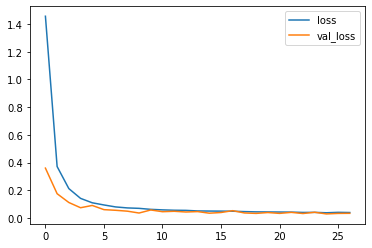

In [ ]:
metrics = pd.DataFrame(model.history.history)
metrics[['loss','val_loss']].plot()
plt.show()

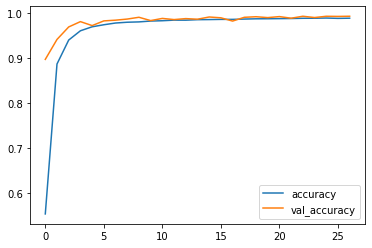

In [ ]:
metrics[['accuracy','val_accuracy']].plot()
plt.show()

In [ ]:
#Prediction
predictions = np.argmax(model.predict(x_test), axis = -1)

1285/1285 [==============================] - 3s 2ms/step


In [ ]:
#Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1444
           1       1.00      1.00      1.00      1547
           2       0.99      1.00      1.00      1343
           3       0.99      1.00      0.99      1626
           4       1.00      1.00      1.00      1460
           5       1.00      1.00      1.00      1773
           6       1.00      1.00      1.00      1658
           7       1.00      1.00      1.00      1585
           8       0.99      1.00      0.99      1574
           9       1.00      0.99      1.00      1701
          10       1.00      1.00      1.00      1674
          11       1.00      1.00      1.00      1620
          12       0.95      0.98      0.97      1148
          13       0.99      0.94      0.96       949
          14       0.99      1.00      0.99      1472
          15       1.00      0.99      0.99      1304
          16       0.99      0.99      0.99      1326
          17       0.99    

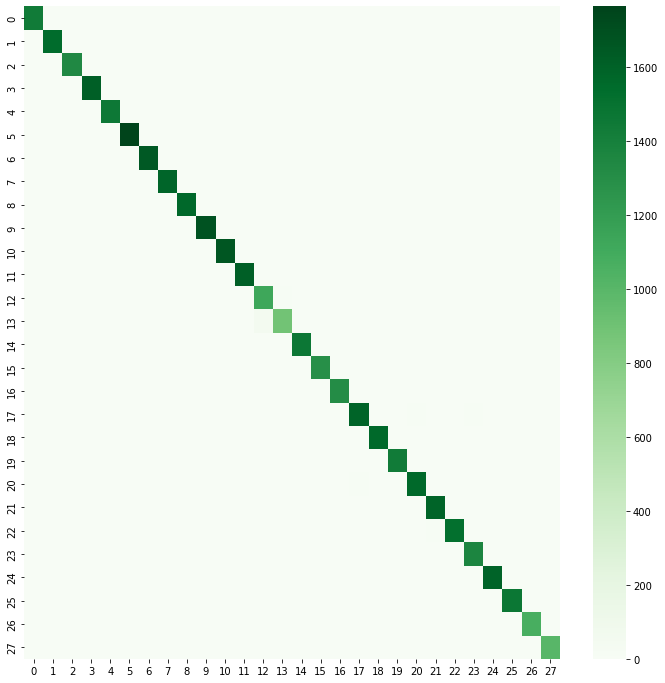

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix(y_test,predictions), cmap = 'Greens')
plt.show()

In [ ]:
#Testing
def predict_image(filename, model):
    image = cv2.imread(filename)
    image = increase_brightness(image, 20)
    # image = cv2.flip(image, 1)
    results = mp_model.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks != None:
        keypoints = extract_keypoints(results)
        # convert_keypoints(keypoints)
        landmark_array = keypoints.reshape(-1,63)
        index = np.argmax(model.predict(landmark_array))
        letterpred = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
                      'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
                      'W', 'X', 'Y', 'Z', 'del', 'space']
        index = letterpred[index]
    else:
        index = 'Nothing'
        
    plt.title("Prediction - {}".format(str(index).title()), size=18, color='red')
    plt.imshow(image)

1/1 [==============================] - 0s 29ms/step


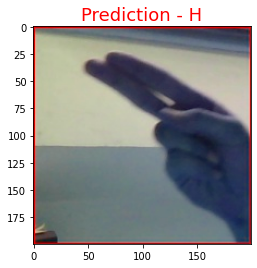

In [ ]:
predict_image('D:/asl_alphabet_test/asl_alphabet_test/H_test.jpg', model)

1/1 [==============================] - 0s 35ms/step


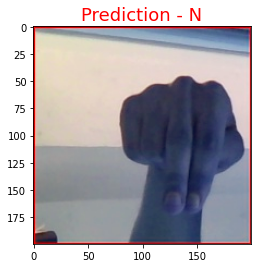

In [ ]:
predict_image('C:/ASL train data/asl_alphabet_train/asl_alphabet_train/N/N789.jpg', model)

In [ ]:
# imgtest = cv2.imread('D:/asl_alphabet_test/asl_alphabet_test/I_test.jpg')
imgtest = cv2.imread('C:/ASL train data/asl_alphabet_train/asl_alphabet_train/A/A535.jpg')
imgtest = increase_brightness(imgtest, 20)
results = mp_model.process(cv2.cvtColor(imgtest, cv2.COLOR_BGR2RGB))
if results.multi_hand_landmarks != None:
    keypoints = extract_keypoints(results)

In [ ]:
landmark_array = x.reshape(1,63,1)
index = np.argmax(model.predict(landmark_array))

1/1 [==============================] - 0s 32ms/step


In [ ]:
labels[1234]

10

In [ ]:
from keras.models import load_model
model = load_model('D:/Model ASL/ASL landmarks using Dense v2.h5')